In [37]:
# Code configuration
DATASET_FILE_NAME = 'dataset_edom'
FEB_ONLY = False

MODEL_NAME = 'indobert'; # mbert, indobert, roberta, gpt2
FREEZE_LAYER = False

# Hyperparameter
BATCH_SIZE = 16 # 16, 32
LEARNING_RATE = 2e-5 # 5e-5, 3e-5, 2e-5
EPOCH = 4 # 2, 3, 4
RANDOM_SEED = 42

In [38]:
import torch
import random
import numpy as np

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

In [39]:
import os
from google.colab import files

if not os.path.exists(f'./{DATASET_FILE_NAME}.xlsx'):
  uploaded = files.upload()

In [40]:
import pandas as pd

df = pd.read_excel(f'./{DATASET_FILE_NAME}.xlsx')

# Pre-processing excel data
df_copy = df.copy()
df_copy = df_copy.drop_duplicates(subset='JAWABAN')
df_copy = df_copy.dropna(subset=['LABEL'])
df_copy = df_copy[df_copy['FAKULTAS'] == 'EKONOMI DAN BISNIS'] if FEB_ONLY else df_copy
df_copy.drop(['KONTEKS', 'FAKULTAS'], axis=1, inplace=True)
df_copy.head()

,JAWABAN,LABEL
0,"Selama proses perkuliahan sudah cukup baik, ha...",NEGATIF
1,selalu menjadi dosen yang memotivasi mahasiswanya,POSITIF
2,tetap jadi dosen yang baik dan seru buk,POSITIF
3,Saya sangat merasa senang ketika belajar di ke...,POSITIF
4,Saran: Jika tidak masuk pada jam yang telah di...,NEGATIF


In [41]:
# Check if there is any null value in df_copy
assert df_copy.isna().sum().sum() == 0, "Error: There are null values in the DataFrame."

print("No null values found.")
print(df_copy.isna().sum())

No null values found.
JAWABAN    0
LABEL      0
dtype: int64


In [42]:
# Pre-process label representation
label_value = df_copy['LABEL'].unique()
print("Original unique values in the 'LABEL' column:", label_value)

if 'NETRAL' in label_value:
    df_copy = df_copy[df_copy['LABEL'] != 'NETRAL'].copy()  # Ensure a copy is created
    print("Rows with 'NETRAL' values dropped.")
else:
    print("No 'NETRAL' values found in the 'LABEL' column.")

# Map label values to numerical values
label_mapping = {'NEGATIF': 0, 'POSITIF': 1}
df_copy['LABEL'] = df_copy['LABEL'].map(label_mapping)

print("Unique values after mapping in the 'LABEL' column:", df_copy['LABEL'].unique())

Original unique values in the 'LABEL' column: ['NEGATIF' 'POSITIF' 'NETRAL']
Rows with 'NETRAL' values dropped.
Unique values after mapping in the 'LABEL' column: [0 1]


In [43]:
total_data = len(df_copy)
total_pos_label = df_copy[df_copy['LABEL'] == 0].shape[0]
total_neg_label = df_copy[df_copy['LABEL'] == 1].shape[0]

print(f'Total Data: {total_data}')
print(f'Total Positive Labels: {total_pos_label}')
print(f'Total Negative Labels: {total_neg_label}')

Total Data: 5783
Total Positive Labels: 2849
Total Negative Labels: 2934


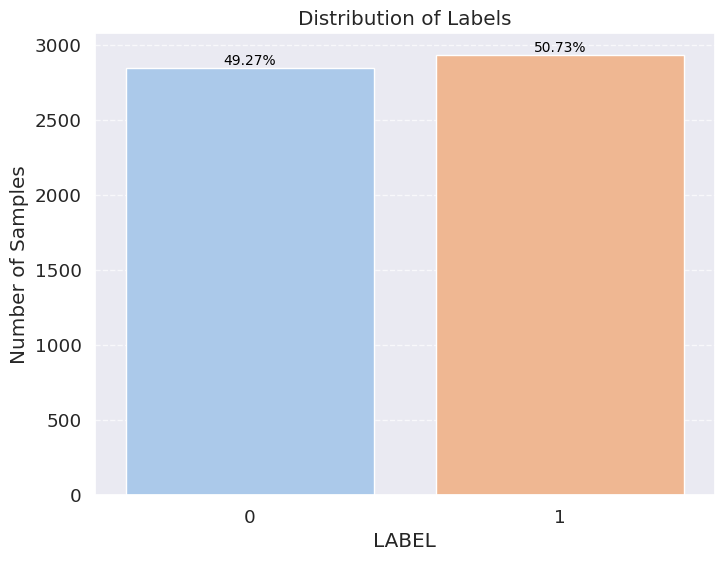

In [44]:
# Plot distribution of labels
import seaborn as sns
import matplotlib.pyplot as plt

colors = sns.color_palette("pastel", 2)
label_counts = df_copy['LABEL'].value_counts()

total_samples = len(df_copy['LABEL'])
percentage_distribution = (label_counts / total_samples) * 100

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=label_counts.index, y=label_counts, palette=colors, hue=label_counts.index, legend=False)

ax.set_ylabel('Number of Samples')
plt.title('Distribution of Labels')

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(f'{percentage_distribution[i]:.2f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black')

ax.yaxis.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [45]:
import pandas as pd

sample_df = df_copy.sample(n=15, random_state=42)

sentences = df_copy['JAWABAN'].values
labels = df_copy['LABEL'].values

print("Random Texts and Labels (Sample of 15 entries):")
for i, (sentence, label) in enumerate(zip(sample_df['JAWABAN'], sample_df['LABEL']), 1):
  print(f"{i}. Label: {label} - Text: {sentence}\n")

Random Texts and Labels (Sample of 15 entries):
1. Label: 0 - Text: Izin pak saran saya, penyampaian materi lebih tegas dan lantang, agar tidak mahasiswa tertarik dan tidak menimbulkan efek ngantuk pak. Terimakasih 

2. Label: 1 - Text: No comment karena kami di ganti kan oleh buk XYZ dan dengan XYZ kami enjoy dan ilmunya yg di ajarkan paham

3. Label: 0 - Text: Pembelajaran dengan beliau sangat baik tetepi beberapa kali jam mata kuliah di ganti tidak sesuai jadwal 

4. Label: 0 - Text: Untuk buk XYZ kedepannya tolong jangan suka php mahasiswa

5. Label: 1 - Text: Menurut saya cara pembelajaran ibu sudah baik, karna ibu menjelaskan kepada mahasiswa terkait materi yang sudah kami persiapkan dengan jelas dan ibu juga memberikan kami saran terkait penulisan ppt yang benar. 

6. Label: 1 - Text: Proses perkuliahan sudah sangat baik, sehingga materi yang sudah disampaikan menjadi lebih mudah untuk dipahami. Semoga proses pembelajaran ke depannya tetap aktif dan mahasiswa bisa lebih bersungg

In [46]:
!pip install transformers -q

In [47]:
from transformers import BertTokenizer, RobertaTokenizer, GPT2Tokenizer
from transformers import BertForSequenceClassification, RobertaForSequenceClassification, GPT2ForSequenceClassification

def load_tokenizer_and_model(MODEL_NAME):
  model_classes = {
    "mbert": (BertTokenizer, BertForSequenceClassification, 'bert-base-multilingual-uncased'),
    "indobert": (BertTokenizer, BertForSequenceClassification, 'indolem/indobert-base-uncased'),
    "roberta": (RobertaTokenizer, RobertaForSequenceClassification, 'cahya/roberta-base-indonesian-522M'),
    "gpt2": (GPT2Tokenizer, GPT2ForSequenceClassification, 'cahya/gpt2-small-indonesian-522M'),
  }

  if MODEL_NAME.lower() not in model_classes:
    raise ValueError(f"Unsupported model: {MODEL_NAME}")

  tokenizer_class, model_class, model_pretrained = model_classes[MODEL_NAME.lower()]

  tokenizer = tokenizer_class.from_pretrained(model_pretrained, do_lower_case=True)
  model = model_class.from_pretrained(model_pretrained, num_labels=2)

  # Set pad_token for GPT-2
  if MODEL_NAME.lower() == 'gpt2':
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id

  return tokenizer, model

In [48]:
tokenizer, model = load_tokenizer_and_model(MODEL_NAME)

if FREEZE_LAYER:
  if MODEL_NAME == 'gpt2':
    # Freeze all layers except the embedding and positional embedding layers
    for param in model.transformer.wte.parameters():
      param.requires_grad = False
    for param in model.transformer.wpe.parameters():
      param.requires_grad = False
  else:
    # Freeze all layers except the final classification layer
    for param in model.parameters():
      param.requires_grad = False

    # Make the classification layer trainable
    for param in model.classifier.parameters():
      param.requires_grad = True

    # Another option freeze all layers and add some layers
    # model.classifier = torch.nn.Sequential(
    #     torch.nn.Linear(model.config.hidden_size, 512),
    #     torch.nn.ReLU(),
    #     torch.nn.Dropout(0.2),
    #     torch.nn.Linear(512, 2)
    # )


# Check the tokenization process results
print("Original Sentence: ", sentences[0])
print("Tokenized Sentence: ", tokenizer.tokenize(sentences[0]))
print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Original Sentence:  Selama proses perkuliahan sudah cukup baik, hanya saja untuk pertemuan terakhir sebelum UAS dosen jarang masuk sehingga materi nya kurang dipahami mahasiswa 
Tokenized Sentence:  ['selama', 'proses', 'perkuliahan', 'sudah', 'cukup', 'baik', ',', 'hanya', 'saja', 'untuk', 'pertemuan', 'terakhir', 'sebelum', 'u', '##as', 'dosen', 'jarang', 'masuk', 'sehingga', 'materi', 'nya', 'kurang', 'dipahami', 'mahasiswa']
Token IDS:  [2015, 2373, 18158, 1798, 2352, 1983, 16, 1821, 2037, 1559, 3369, 2676, 1940, 63, 1486, 6169, 5395, 2410, 2081, 3901, 2647, 2677, 8848, 2928]


In [49]:
tokenizer

BertTokenizer(name_or_path='indolem/indobert-base-uncased', vocab_size=31923, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [50]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  model.cuda()
  print(f'There are {torch.cuda.device_count()} GPU(s) available. GPU: {torch.cuda.get_device_name(0)}')
else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

There are 1 GPU(s) available. GPU: Tesla T4


In [51]:
# Max sentence length and encode the sentence and add special tokens (e.g., [CLS] and [SEP])
max_len = 0

for sentence in sentences:
  input_ids = tokenizer.encode(sentence, add_special_tokens=True)
  max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

# MAX_LEN = 64 if max_len <= 64 else (128 if max_len <= 128 else (256 if max_len <= 256 else 512))
MAX_LEN = 256
print(f"Recommended MAX_LEN: {MAX_LEN}")

Max sentence length:  246
Recommended MAX_LEN: 256


In [52]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sentence in sentences:
  encoded_dict = tokenizer.encode_plus(
    sentence,
    add_special_tokens = True,
    max_length = MAX_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask = True,
    return_tensors = 'pt'
  )

  input_ids.append(encoded_dict['input_ids'])
  attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Selama proses perkuliahan sudah cukup baik, hanya saja untuk pertemuan terakhir sebelum UAS dosen jarang masuk sehingga materi nya kurang dipahami mahasiswa 
Token IDs: tensor([    3,  2015,  2373, 18158,  1798,  2352,  1983,    16,  1821,  2037,
         1559,  3369,  2676,  1940,    63,  1486,  6169,  5395,  2410,  2081,
         3901,  2647,  2677,  8848,  2928,     4,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     

In [53]:
# Training, validation, and test split
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

total_size = len(dataset)
train_size = int(0.8 * total_size)
remaining_size = total_size - train_size
val_size = test_size = remaining_size // 2

if remaining_size % 2 != 0:
  train_size += 1

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

4,627 training samples
  578 validation samples
  578 test samples


In [54]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = BATCH_SIZE

train_dataloader = DataLoader(
  train_dataset,
  sampler = RandomSampler(train_dataset),
  batch_size = batch_size
)

validation_dataloader = DataLoader(
  val_dataset,
  sampler = SequentialSampler(val_dataset),
  batch_size = batch_size
)

test_dataloader = DataLoader(
  test_dataset,
  sampler = SequentialSampler(test_dataset),
  batch_size = batch_size
)

In [55]:
train_dataloader, validation_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7dfa5d163760>,
 <torch.utils.data.dataloader.DataLoader at 0x7dfa5d163010>)

In [56]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The {} model has {:,} different named parameters.\n'.format(
    MODEL_NAME.upper(),
    len(params)
))

sections = {
  'Embedding Layer': params[0:5],
  'First Transformer': params[5:21],
  'Output Layer': params[-4:]
}

for section, parameters in sections.items():
  print(f'==== {section} ====\n')
  for p in parameters:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
  print()

The INDOBERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (31923, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias           

In [57]:
# Optimizer setup
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 2e-05
    maximize: False
    weight_decay: 0.01
)

In [58]:
# Learning rate scheduler
from transformers import get_linear_schedule_with_warmup

epochs = EPOCH
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [59]:
scheduler

In [60]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [61]:
import time
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round((elapsed)))

  # Format as hh:mm:ss
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [62]:
training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
  # ========================================
  #               Training
  # ========================================
  print("")
  print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
  print("Training...")

  # Measure how long the training epoch takes.
  t0 = time.time()

  # Reset the total loss for this epoch.
  total_train_loss = 0

  # Put the model into training mode.
  model.train()

  for step, batch in enumerate(train_dataloader):
    if step % 40 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print("Batch {:>5,} of {:>5,}.  Elapsed: {:}".format(step, len(train_dataloader), elapsed))

    # Unpack this training batch from our dataloader.
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Clear any previously calculated gradients before performing a backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    result = model(
      b_input_ids,
      token_type_ids=None,
      attention_mask=b_input_mask,
      labels=b_labels,
      return_dict=True
    )

    loss = result.loss
    logits = result.logits

    total_train_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

  # Calculate the average loss over all of the batches.
  avg_train_loss = total_train_loss / len(train_dataloader)

  training_time = format_time(time.time() - t0)

  print("   Average training loss: {0:.2f}".format(avg_train_loss))
  print("   Training epoch took: {:}".format(format_time(time.time() - t0)))

  # ========================================
  #               Validation
  # ========================================
  print("")
  print("Running Validation...")
  t0 = time.time()

  # Put the model in evaluation mode
  model.eval()

  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Unpack this training batch from our dataloader.
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(
        b_input_ids,
        token_type_ids=None,
        attention_mask=b_input_mask,
        labels=b_labels,
        return_dict=True
      )

    # Get the loss and "logits" output by the model.
    loss = result.loss
    logits = result.logits

    total_eval_loss += loss.item()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences, and
    # accumulate it over all batches.
    total_eval_accuracy += flat_accuracy(logits, label_ids)

  # Report the final accuracy for this validation run.
  avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(validation_dataloader)

  # Measure how long the validation run took.
  validation_time = format_time(time.time() - t0)

  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))

  # Record all statistics from this epoch.
  training_stats.append(
    {
      'epoch': epoch_i + 1,
      'Training Loss': avg_train_loss,
      'Valid. Loss': avg_val_loss,
      'Valid. Accur.': avg_val_accuracy,
      'Training Time': training_time,
      'Validation Time': validation_time
    }
  )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======= Epoch 1 / 4 =======
Training...
Batch    40 of   290.  Elapsed: 0:00:27
Batch    80 of   290.  Elapsed: 0:00:55
Batch   120 of   290.  Elapsed: 0:01:21
Batch   160 of   290.  Elapsed: 0:01:48
Batch   200 of   290.  Elapsed: 0:02:16
Batch   240 of   290.  Elapsed: 0:02:43
Batch   280 of   290.  Elapsed: 0:03:10
   Average training loss: 0.34
   Training epoch took: 0:03:16

Running Validation...
  Accuracy: 0.92
  Validation Loss: 0.27
  Validation took: 0:00:09

======= Epoch 2 / 4 =======
Training...
Batch    40 of   290.  Elapsed: 0:00:27
Batch    80 of   290.  Elapsed: 0:00:54
Batch   120 of   290.  Elapsed: 0:01:21
Batch   160 of   290.  Elapsed: 0:01:48
Batch   200 of   290.  Elapsed: 0:02:15
Batch   240 of   290.  Elapsed: 0:02:42
Batch   280 of   290.  Elapsed: 0:03:09
   Average training loss: 0.21
   Training epoch took: 0:03:16

Running Validation...
  Accuracy: 0.93
  Validation Loss: 0.25
  Validation took: 0:00:09

======= Epoch 3 / 4 =======
Training...
Batch    

In [63]:
import pandas as pd

pd.set_option('display.precision', 2)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.34,0.27,0.92,0:03:16,0:00:09
2,0.21,0.25,0.93,0:03:16,0:00:09
3,0.16,0.24,0.93,0:03:16,0:00:09
4,0.11,0.30,0.93,0:03:16,0:00:09


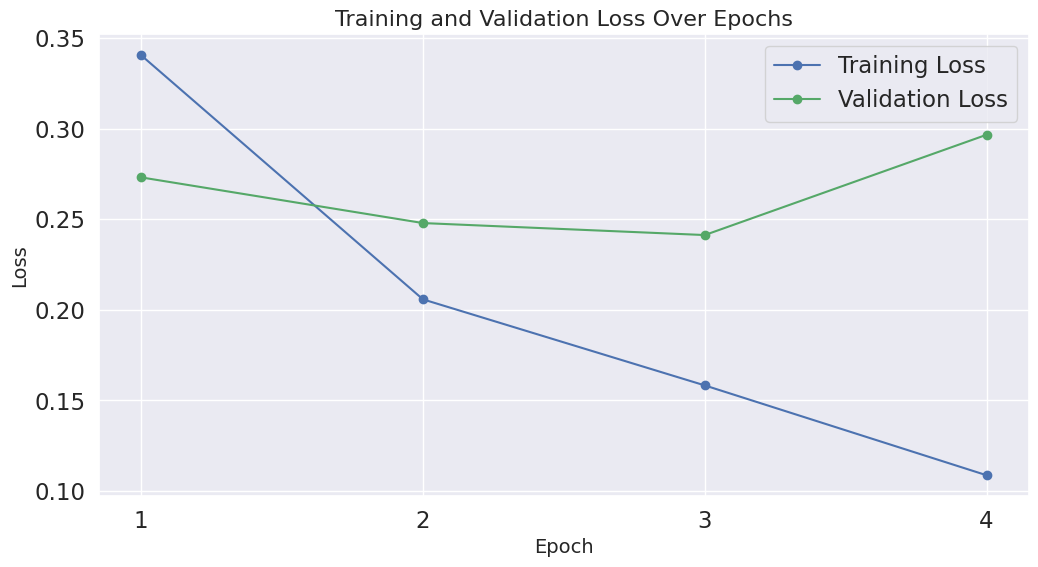

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid', font_scale=1.5)

plt.rcParams["figure.figsize"] = (12, 6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training Loss")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation Loss")

plt.title("Training and Validation Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)

plt.legend()
plt.xticks(range(1, len(df_stats) + 1))

plt.show()

In [65]:
# Prediction on test set
print("Predicting labels for {:,} test sentences...".format(len(test_dataset)))

# Put model in evaluation mode
model.eval()

predictions, true_labels = [], []

for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    # Forward pass, calculate logit predictions.
    result = model(
      b_input_ids,
      token_type_ids=None,
      attention_mask=b_input_mask,
      return_dict=True
    )

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 578 test sentences...
    DONE.


In [66]:
total_samples = len(test_dataloader.dataset)
positive_samples = sum(batch[2].sum().item() for batch in test_dataloader)

percentage_positive = (positive_samples / total_samples) * 100

# use MCC here because the classes are imbalanced
print('Positive samples: %d of %d (%.2f%%)' % (positive_samples, total_samples, percentage_positive))

Positive samples: 278 of 578 (48.10%)


In [67]:
# MCC for imbalanced data
from sklearn.metrics import matthews_corrcoef

matthews_set = []
print('Calculating Matthews Corr. Coef. for each batch...')

for i in range(len(true_labels)):
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
    matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


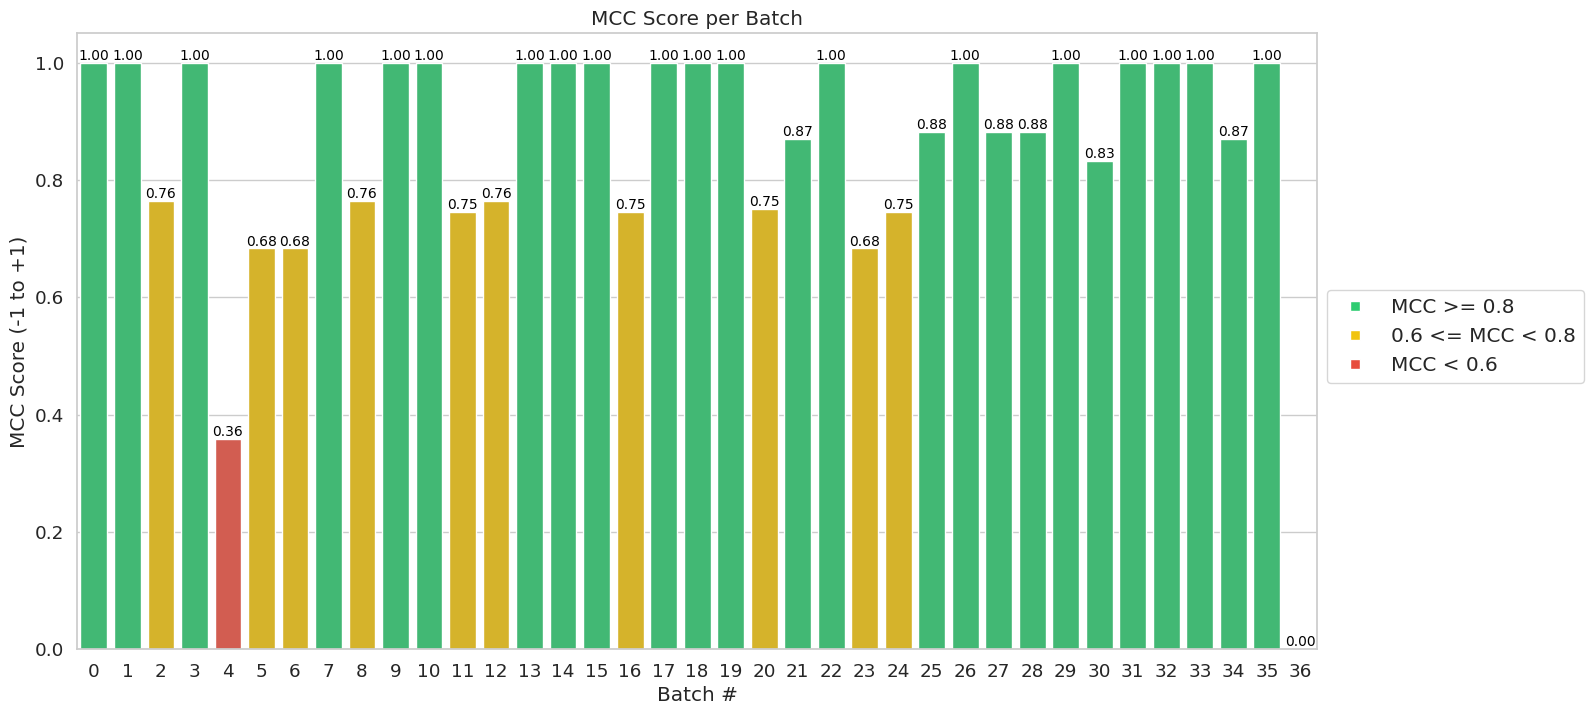

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

sns.set(style='whitegrid', font_scale=1.2)
plt.rcParams["figure.figsize"] = (16, 8)

colors = ['#2ecc71' if mcc >= 0.8 else '#f1c40f' if mcc >= 0.6 else '#e74c3c' for mcc in matthews_set]
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, hue=list(range(len(matthews_set))), palette=colors, legend=False)

legend_markers = [
    Line2D([0], [0], marker='s', color='w', label='MCC >= 0.8', markersize=7, markerfacecolor='#2ecc71'),
    Line2D([0], [0], marker='s', color='w', label='0.6 <= MCC < 0.8', markersize=7, markerfacecolor='#f1c40f'),
    Line2D([0], [0], marker='s', color='w', label='MCC < 0.6', markersize=7, markerfacecolor='#e74c3c')
]

plt.legend(handles=legend_markers, loc='upper left', bbox_to_anchor=(1, 0.6), fontsize='medium')
plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(f'{matthews_set[i]:.2f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black')

plt.show()

In [69]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)

mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
print('Total MCC: %.3f' % mcc)

Total MCC: 0.882


In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
acc = accuracy_score(flat_true_labels, flat_predictions)
precision = precision_score(flat_true_labels, flat_predictions)
recall = recall_score(flat_true_labels, flat_predictions)
f1 = f1_score(flat_true_labels, flat_predictions)

# Display metrics
print(f"Overall Metrics:")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Overall Metrics:
Accuracy: 0.941
Precision: 0.945
Recall: 0.932
F1 Score: 0.938


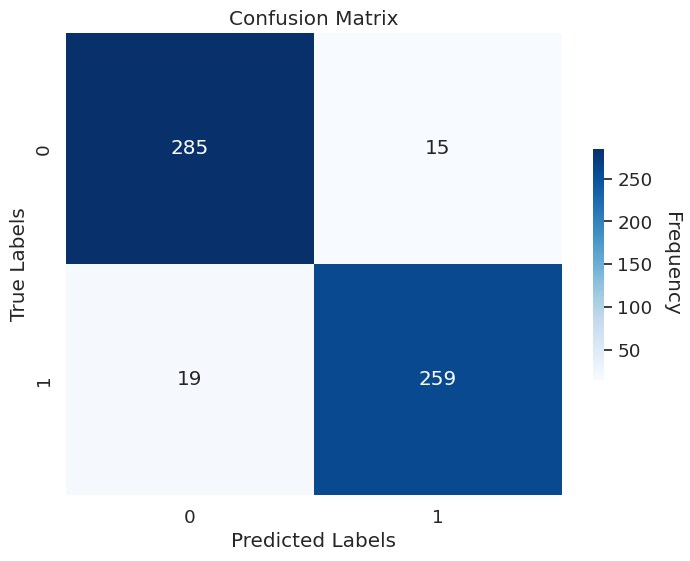

In [71]:
# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

conf_matrix = confusion_matrix(flat_true_labels, flat_predictions)
class_labels = unique_labels(flat_true_labels, flat_predictions)

sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))

ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar_kws={"shrink": 0.5})

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Add color bar legend
cbar = ax.collections[0].colorbar
cbar.set_label('Frequency', rotation=270, labelpad=20)

plt.show()

In [72]:
from sklearn.metrics import classification_report

# Display Classification Report
class_report = classification_report(flat_true_labels, flat_predictions)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       300
           1       0.95      0.93      0.94       278

    accuracy                           0.94       578
   macro avg       0.94      0.94      0.94       578
weighted avg       0.94      0.94      0.94       578

